# Bayesian Bootstrapped CNN

A bootstrapped approach to domain adaptation for MNIST to USPS using a Bayesian CNN.

Author: @ysbecca

Credits go to:

- [Hvass-Labs](http://www.hvass-labs.org/) for the base CNN model for MNIST classification. Their CNN was deepened and adjusted to iteratively learn the USPS dataset.
- [Leo Pauly](https://github.com/leopauly) for the research interest in general and the initial code which loads the datasets.
- Kyle Dorman, Yarin Gal, Alex Kendall for their work in Bayesian deep learning.

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from datetime import timedelta
from importlib import reload
import math
import time

# Custom scripts.
import ysb
import dataset
import mnist_usps as mnus
import cnn_helper as cn

In [2]:
reload(mnus)
reload(dataset)
reload(cn)
reload(ysb)

<module 'ysb' from '/Users/ysbecca/ysbecca-projects/Domain-Adaptation/MNIST_USPS_Dataset/ysb.py'>

Set parameters.

In [16]:
# CNN PARAMETERS
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

filter_size2 = 5         
num_filters2 = 16    

filter_size3 = 5         
num_filters3 = 16    

filter_size4 = 5         
num_filters4 = 16

filter_size5 = 5         
num_filters5 = 16

fc_size1 = 1024
fc_size2 = 128             

# IMAGE PARAMETERS
img_size = 16             # Width and height in pixels.

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

## Load both datasets.

In [13]:
mnist_data, usps_data = dataset.read_datasets()

In [14]:
print("MNIST dataset:")
print("- Training-set:\t\t{}".format(mnist_data.train.num_images))
print("- Test-set:\t\t{}".format(mnist_data.test.num_images))
print("- Validation-set:\t{}".format(mnist_data.valid.num_images))

print("USPS dataset:")
print("- Training-set:\t\t{}".format(usps_data.train.num_images))
print("- Test-set:\t\t{}".format(usps_data.test.num_images))

MNIST dataset:
- Training-set:		49000
- Test-set:		14000
- Validation-set:	7000
USPS dataset:
- Training-set:		7439
- Test-set:		1859


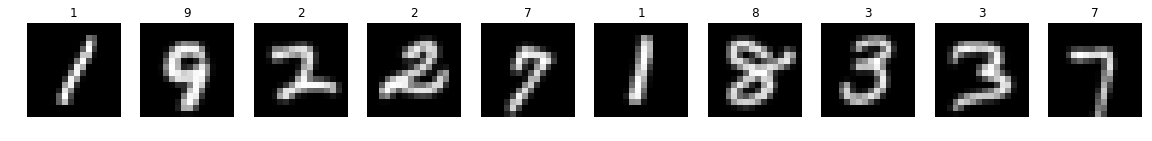

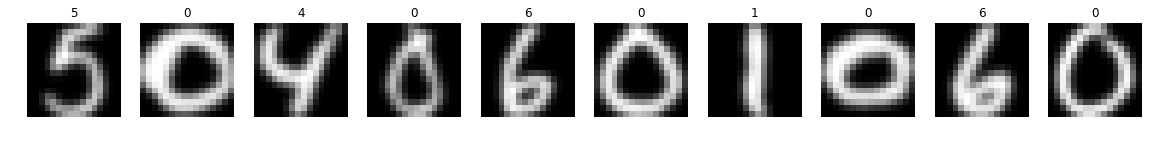

In [15]:
i = 0
to_show = 10
ysb.show_labeled_patches_gray(mnist_data.train.images[i:(i+to_show)], mnist_data.train.cls[i:(i+to_show)])
ysb.show_labeled_patches_gray(usps_data.train.images[i:(i+to_show)], usps_data.train.cls[i:(i+to_show)])

## Train the CNN on MNIST.

First, set up the placeholders.

In [17]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1) # A placeholder only, so calculated instead of passed directly.

# aleatoric variance, which our BNN will output in addition to the softmax output
# a_variance = tf.placeholder(tf.float32, shape=[None, 1])

keep_prob = tf.placeholder(tf.float32) # So we can turn off dropout for training, but on for testing.

Build TensorFlow graph for a simple 5-layer CNN with max-pooling, ReLU and two fully-connected layers.

In [18]:
layer_conv1, weights_conv1 = \
    cn.new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True,
                   w_name="conv1_w")
layer_conv2, weights_conv2 = \
    cn.new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True,
                   w_name="conv2_w")
layer_drop2 = tf.nn.dropout(layer_conv2, keep_prob)
layer_conv3, weights_conv3 = \
    cn.new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True,
                   w_name="conv3_w")
layer_conv4, weights_conv4 = \
    cn.new_conv_layer(input=layer_conv3,
                   num_input_channels=num_filters3,
                   filter_size=filter_size4,
                   num_filters=num_filters4,
                   use_pooling=True,
                   w_name="conv4_w")
layer_conv5, weights_conv5 = \
    cn.new_conv_layer(input=layer_conv4,
                   num_input_channels=num_filters4,
                   filter_size=filter_size5,
                   num_filters=num_filters5,
                   use_pooling=True,
                   w_name="conv5_w")
    
# We want low or no dropout during training, and high dropout for Monte Carlo sampling.
layer_drop5 = tf.nn.dropout(layer_conv5, keep_prob)       

layer_flat, num_features = cn.flatten_layer(layer_conv3)
layer_fc1 = cn.new_fc_layer(input=layer_flat,                # num_features = 128, from the flattened 3rd layer.
                         num_inputs=num_features,
                         num_outputs=fc_size1,
                         use_relu=True,
                         w_name="fc1_w")
layer_fc2 = cn.new_fc_layer(input=layer_fc1,                # num_features = 128, from the flattened 3rd layer.
                         num_inputs=fc_size1,
                         num_outputs=fc_size2,
                         use_relu=True,
                         w_name="fc2_w")
layer_fc3 = cn.new_fc_layer(input=layer_fc2,                 # This is the classification layer.
                         num_inputs=fc_size2,
                         num_outputs=num_classes,            # num_classes = 10
                         use_relu=False,
                         w_name="fc3_w")
y_pred = tf.nn.softmax(layer_fc3)                            # This is the softmax output prediction.
y_pred_cls = tf.argmax(y_pred, dimension=1)                  # The hard classification, with a threshold of 0.5.

In [19]:
# Cost to be reduced is the the cross entropy over all the images.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc3, labels=y_true)

# Modified loss function

cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Now we create a new TensorFlow session and initialise the variables.

In [20]:
tf.set_random_seed(1)
np.random.seed(0)

session = tf.Session()
session.run(tf.global_variables_initializer())
train_batch_size = 128
test_batch_size = 128

saver = tf.train.Saver()

Helper functions for running optimisation iterations and showing test accuracy.

In [21]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(dataset_train, num_iterations, silent=False, dropout_keep_prob=1.0):
    global total_iterations
    start_time = time.time()
    for i in range(total_iterations,
                   total_iterations + num_iterations):
        x_batch, y_true_batch = dataset_train.next_batch(train_batch_size)
        x_batch = x_batch.reshape(len(x_batch), img_size_flat)
        feed_dict_train = {x: x_batch, y_true: y_true_batch, keep_prob: dropout_keep_prob}

        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 250 iterations.
        if i % 250 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            if not silent:
                msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
                print(msg.format(i + 1, acc))

    total_iterations += num_iterations

    end_time = time.time()
    time_dif = end_time - start_time
    if not silent:
        print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
def print_test_accuracy(dataset_test, show_confusion_matrix=True, quieter=False, silent=False):
    num_test = len(dataset_test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        curr_batch_size = j - i
        
        # Get the images and targets from the test-set between index i and j.
        images = dataset_test.images[i:j, :].reshape(curr_batch_size, img_size_flat)
        labels = dataset_test.labels[i:j, :]
        feed_dict = {x: images, y_true: labels}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j

    cls_true = dataset_test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test

    msg = "Accuracy on test set: {0:.1%} ({1} / {2})"
    if not quieter:
        print(msg.format(acc, correct_sum, num_test))
    else:
        if not silent:
            print("{0:.1%}".format(acc))
    
    if show_confusion_matrix:
        cn.plot_confusion_matrix(cls_true, cls_pred=cls_pred)
    return acc

Train CNN.

In [22]:
print_test_accuracy(mnist_data.test, show_confusion_matrix=False)

Accuracy on test set: 9.6% (1350 / 14000)


0.09642857142857143

In [23]:
optimize(mnist_data.train, num_iterations=2000, silent=True, dropout_keep_prob=1.0)

KeyboardInterrupt: 

In [15]:
print_test_accuracy(mnist_data.test, show_confusion_matrix=False)

Accuracy on test set: 92.2% (12901 / 14000)


0.9215

In [16]:
optimize(mnist_data.train, num_iterations=10000, silent=True, dropout_keep_prob=1.0)

In [17]:
print_test_accuracy(mnist_data.test, show_confusion_matrix=False)

Accuracy on test set: 97.6% (13664 / 14000)


0.976

Now we save the CNN model which has been trained on MNIST.

In [18]:
saver.save(sess=session, save_path='checkpoints/')

'checkpoints/'

## Now compute prediction and epistemic uncertainty (approximated) on USPS dataset

"We can model epistemic uncertainty in deep learning models using Monte Carlo dropout sampling at test time.
Dropout sampling can be interpreted as sampling from a distribution over models."

Credits:

- Alex Kendall's presentation: https://alexgkendall.com/media/presentations/oxford_seminar.pdf
- Yarin Gal's paper "Dropout as a Bayesian Approximation Representing Model Uncertainty in Deep Learning" http://proceedings.mlr.press/v48/gal16.pdf
- Kyle Dorman's post "Building a Bayesian Deep Learning Classifier" https://medium.com/towards-data-science/building-a-bayesian-deep-learning-classifier-ece1845bc09

Now test on USPS test set, then run the CNN on the entire training set (we treat the training set as if it is completely unlabeled) and save softmax outputs.

Accuracy on test set: 60.8% (1130 / 1859)
[[249   2  20   3   0   3  13   0  25   0]
 [  0  58   1   1   0   0   0   0 206   0]
 [  0   0 140  18   0   0   1   0  12   0]
 [  0   0   3 169   0   0   0   0   9   0]
 [  0   1   1   2 121   0   9   5   9   8]
 [  1   0   0  56   0  74   2   0  20   0]
 [  0   0   0   0   0   0 158   0  11   0]
 [  0  65  65  17   0   0   0  15   7   0]
 [  0   0   0   0   0   1   1   0 138   0]
 [  0   1   2  36  27   1   0  10  54   8]]


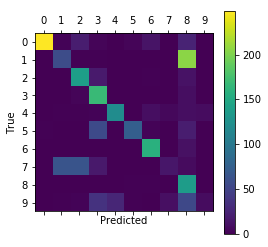

0.6078536847767617

In [19]:
print_test_accuracy(usps_data.test, show_confusion_matrix=True)

In [20]:
# T is the number of iterations for sampling.
def monte_carlo_preds(dataset_test, T, show_confusion_matrix=True, quieter=False, silent=False):
    num_test = len(dataset_test.images)
    all_cls_preds = np.zeros(shape=(T, num_test, 10), dtype=np.float64)
    cls_true = dataset_test.cls
    
    if num_test == 0:
        return [], []
    
    for k in range(T):
        i = 0
        cls_preds = np.zeros(shape=(num_test, 10), dtype=np.float64)
        
        while i < num_test:
            j = min(i + test_batch_size, num_test)
            curr_batch_size = j - i

            # Get the images and targets from the test-set between index i and j.
            images = dataset_test.images[i:j, :].reshape(curr_batch_size, img_size_flat)
            labels = dataset_test.labels[i:j, :]
            feed_dict = {x: images, y_true: labels, keep_prob: 0.1}

            # For each T iterations, we want all the softmax outputs from each prediction (N, 10)
            # where N is the input size. all_cls_preds should have shape (T, N, 10).
            cls_preds[i:j] = session.run(y_pred, feed_dict=feed_dict)
            i = j

        all_cls_preds[k] = cls_preds

    # (N, 10)
    prediction_probabilities = np.mean(all_cls_preds, axis=0)

    # (N) one variance for each input.
    prediction_variances = np.apply_along_axis(predictive_entropy, axis=1, arr=prediction_probabilities) 

    return prediction_probabilities, prediction_variances

def predictive_entropy(prediction_probabilities):
    return -1 * np.sum(np.log(prediction_probabilities) * prediction_probabilities, axis=0)

def retrieve_predictions(dataset):
    ''' Retrieves the probabilities (not predicted classes) on the given DataSet object. '''
    num_test = len(dataset.images)

    # Allocate an array for the class probabilities which will be calculated in batches and added
    # onto this array; this first element is a dummy to maintain shape as we will add in batches.
    cls_prob = np.zeros(shape=(1, num_classes), dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        curr_batch_size = j - i
        images = dataset.images[i:j, :].reshape(curr_batch_size, img_size_flat)
        labels = dataset.labels[i:j, :]
        feed_dict = {x: images, y_true: labels, keep_prob: 1.0}

        # Save the softmax output.
        cls_prob = np.concatenate((cls_prob, session.run(y_pred, feed_dict=feed_dict)), axis=0)
        i = j
    
    cls_prob = np.delete(cls_prob, 0, 0) # Remove the first dummy element now.
    return cls_prob


## Experimenting with different thresholds, number of iterations, & threshold rates.

Remember to reset the CNN model back to the checkpoint before each new experiment, as well as re-designating the dataset so that all MNIST images are training images, and the USPS set is divided into test (labelled) and train (unlabelled).

In [21]:
saver.restore(sess=session, save_path='checkpoints/')
data = dataset.generate_combined_dataset(mnist_data, usps_data)

INFO:tensorflow:Restoring parameters from checkpoints/


In [22]:
preds, uncertainties = monte_carlo_preds(data.usps_train, 2, show_confusion_matrix=True, quieter=True)

First we will demonstrate that cases exist where bootstrapping using the softmax threshold would result in mislabelling, whereas the epistemic uncertainty provides a warning that the classifier is uncertain.

Labels: Epistemic uncertainty, softmax prediction, actual class.


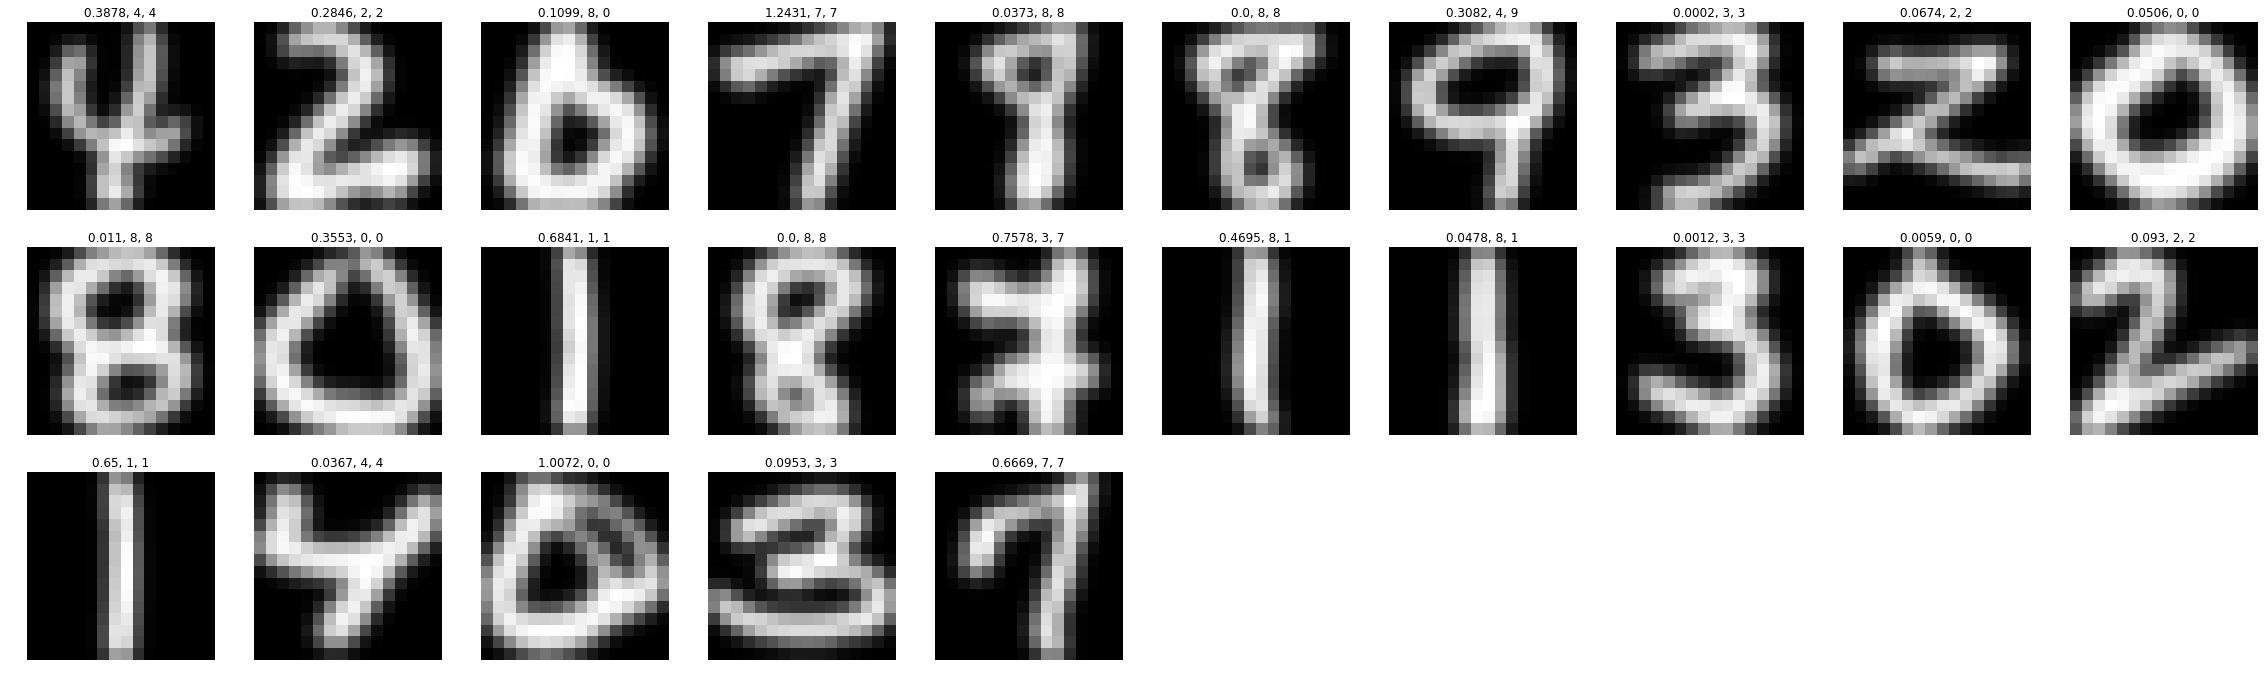

In [23]:
i = 0
to_show = 30

printed_uncertainty = [round(a, 4) for a in uncertainties]
print("Labels: Epistemic uncertainty, softmax prediction, actual class.")

ysb.show_images_with_three_labels_gray(data.usps_train.images[i:(i+to_show)], printed_uncertainty[i:(i+to_show)], \
                                       np.argmax(preds[i:to_show], axis=1), data.usps_train.cls[i:to_show])

### Experiment 1: repeated iterations of labeling unlabeled images with LOW epistemic uncertainty.

In [24]:
bootstrap_iterations = 75
exp1_acc = []
exp1_adds = []

print("-- Experiment 1 --")

for i in range(bootstrap_iterations):
    # Run Monte Carlo sampling iterations to calculate epistemic uncertainty.
    preds, uncertainties = monte_carlo_preds(data.usps_train, 100, show_confusion_matrix=False, quieter=True)
    selected = np.where(uncertainties < 0.5, 1, 0)
    
    if np.count_nonzero(selected) >= data.train.num_images or np.count_nonzero(selected) == 0:
        print("Ending iterations early.")
        break
    
    exp1_adds.append(np.count_nonzero(selected))
    data.train.add_to_set(selected, data.usps_train, preds)
    data.usps_train.remove_from_set(selected)
    
    optimize(data.train, num_iterations=1000, silent=True)
    exp1_acc.append(print_test_accuracy(data.test, show_confusion_matrix=False, quieter=True, silent=True))

-- Experiment 1 --
Ending iterations early.


In [25]:
print("Best percent accuracy: " + str(np.max(exp1_acc)))

Best percent accuracy: 0.645508337816


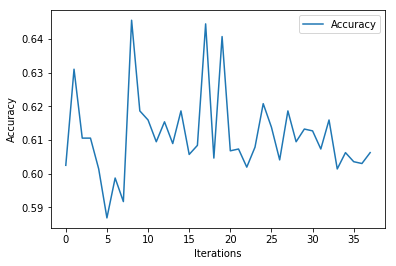

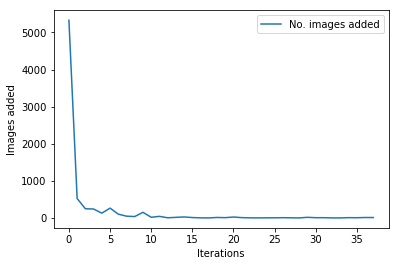

In [26]:
ysb.plot_with_legend(np.arange(len(exp1_acc)), [exp1_acc], ["Accuracy"], "Iterations", "Accuracy")
ysb.plot_with_legend(np.arange(len(exp1_adds)), [exp1_adds], ["No. images added"], "Iterations", "Images added")

### Experiment 2: repeated iterations of labeling unlabeled images with LOW epistemic uncertainty if the softmax output is HIGH.

In [27]:
saver.restore(sess=session, save_path='checkpoints/')
data = dataset.generate_combined_dataset(mnist_data, usps_data)

INFO:tensorflow:Restoring parameters from checkpoints/


In [28]:
exp2_acc = []
exp2_adds = []

print("-- Experiment 2 --")

for i in range(bootstrap_iterations):
    usps_train_preds = retrieve_predictions(data.usps_train)
    softmax_selected = cn.split_by_threshold(0.99, usps_train_preds, silent=True)
    
    preds, uncertainties = monte_carlo_preds(data.usps_train, 100, show_confusion_matrix=False, quieter=True)
    bay_selected = np.where(uncertainties < 0.5, 1, 0)
    
    selected = np.zeros((len(bay_selected)))
    for j, s in enumerate(softmax_selected):
        if s > 0 and bay_selected[j] > 0:
            selected[j] = 1
    
    if np.count_nonzero(selected) >= data.train.num_images or np.count_nonzero(selected) == 0:
        print("Ending iterations early.")
        break
        
    exp2_adds.append(np.count_nonzero(selected))
    data.train.add_to_set(selected, data.usps_train, preds)
    data.usps_train.remove_from_set(selected)
    
    optimize(data.train, num_iterations=1000, silent=True)
    exp2_acc.append(print_test_accuracy(data.test, show_confusion_matrix=False, quieter=True, silent=True))

-- Experiment 2 --
Ending iterations early.


In [29]:
print("Best percent accuracy: " + str(np.max(exp2_acc)))

Best percent accuracy: 0.698762775686


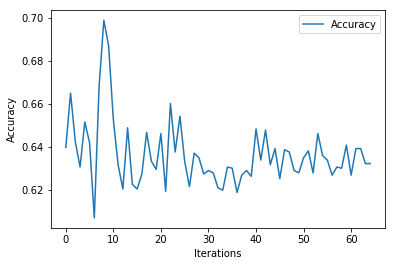

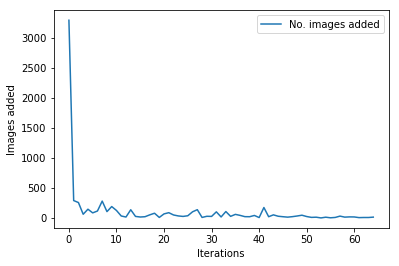

In [30]:
ysb.plot_with_legend(np.arange(len(exp2_acc)), [exp2_acc], ["Accuracy"], "Iterations", "Accuracy")
ysb.plot_with_legend(np.arange(len(exp2_adds)), [exp2_adds], ["No. images added"], "Iterations", "Images added")

### Experiment 3: repeated iterations of labeling unlabeled images with lower softmax output IF the epistemic uncertainty is low (ie, trust uncertainty more than the softmax output)

In [31]:
exp3_acc = []
exp3_adds = []

print("-- Experiment 3 --")

for i in range(bootstrap_iterations):
    usps_train_preds = retrieve_predictions(data.usps_train)
    softmax_selected = cn.split_by_threshold(0.8, usps_train_preds, silent=True)
    
    preds, uncertainties = monte_carlo_preds(data.usps_train, 100, show_confusion_matrix=False, quieter=True)
    bay_selected = np.where(uncertainties < 0.5, 1, 0)
    
    selected = softmax_selected
    for j, s in enumerate(softmax_selected):
        if bay_selected[j] > 0:
            selected[j] = 0 # Unselect the ones
    
    if np.count_nonzero(selected) >= data.train.num_images or np.count_nonzero(selected) == 0:
        print("Ending iterations early.")
        break
        
    exp3_adds.append(np.count_nonzero(selected))
    data.train.add_to_set(selected, data.usps_train, preds)
    data.usps_train.remove_from_set(selected)
    
    optimize(data.train, num_iterations=1000, silent=True)
    exp3_acc.append(print_test_accuracy(data.test, show_confusion_matrix=False, quieter=True, silent=True))

-- Experiment 3 --
Ending iterations early.


In [32]:
print("Best percent accuracy: " + str(np.max(exp3_acc)))

Best percent accuracy: 0.639053254438


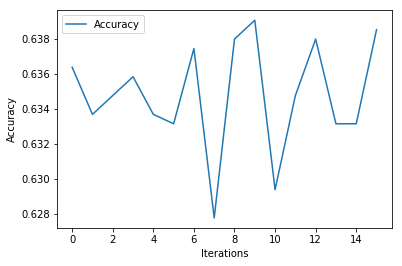

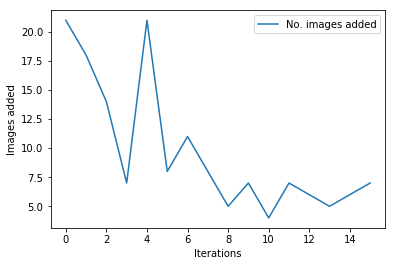

In [33]:
ysb.plot_with_legend(np.arange(len(exp3_acc)), [exp3_acc], ["Accuracy"], "Iterations", "Accuracy")
ysb.plot_with_legend(np.arange(len(exp3_adds)), [exp3_adds], ["No. images added"], "Iterations", "Images added")

## Comparison from both experiments.

In [34]:
x_range = min(len(exp1_acc), len(exp2_acc), len(exp3_acc))

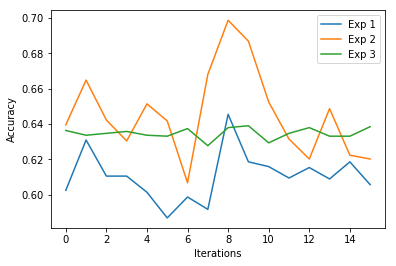

In [35]:
ysb.plot_with_legend(np.arange(x_range), [exp1_acc[:x_range], exp2_acc[:x_range], exp3_acc[:x_range]], ["Exp 1", "Exp 2", "Exp 3"], "Iterations", "Accuracy")

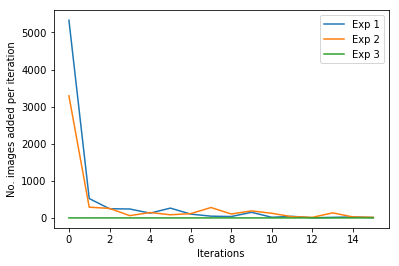

In [36]:
ysb.plot_with_legend(np.arange(x_range), [exp1_adds[:x_range], exp2_adds[:x_range], exp3_acc[:x_range]], ["Exp 1", "Exp 2", "Exp 3"], "Iterations", "No. images added per iteration")

## Close TensorFlow session

Releases all resources! Run only when prepared to lose saved CNN model.

In [37]:
session.close()